# GRU(Gated Recurrent Units) 모델
- https://arxiv.org/pdf/1406.1078
- LSTM의 RNN의 한계점인 기억력 소실문제를 해결하여 긴 sequence의 데이터에서도 좋은 성능을 내는 모델이다. 그러나 복잡한 구조로 parameter가 많아지게 되었고 연산량이 많은 문제점이 있다.
    - parameter가 많아지면서 데이터양이 부족할 경우 과대적합이 발생하고 연산량이 많아 학습에 많은 시간이 걸리게 된다.
- LSTM의 이런 문제를 개선하기 위한 변형 모델이 GRU이다.

## LSTM과 차이
1. LSTM은 forget gate, input gate, output gete 세개의 Gate연산을 함. GRU는 **reset gate와 update gate** 로 흐름을 제어한다.
2. LSTM은 이전 처리결과로 Cell State, Hidden State 두개가 있었는데 이것을 하나로 합쳐 **Hidden State**로 출력한다.

## GRU 성능
- GRU는 적은 파라미터 수와 연산비용이 적게 드는 것에 비해 LSTM과 비슷한 성능을 내는 것으로 알려졌다.

## GRU Cell 구조

![gru_cell](figures/rnn/23_gru_cell.png)    
[이미지 Source](https://www.oreilly.com/library/view/advanced-deep-learning/9781789956177/8ad9dc41-3237-483e-8f6b-7e5f653dc693.xhtml)

- **Reset Gate**
    - 이전 timestep까지의 hidden state(feature)를 현재 timestep의 hidden state(feature) 계산시 얼마나 반영할 지 비율을 결정하는 gate.
    - $r_{t} = \sigma(h_{t-1}\cdot U_{r} + X_{t}\cdot W_{r})$
        - $U_{r},\, W_{r}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
- **Update Gate**
    - 현재 timestep의 hidden state($h_t$)를 계산할 때 이전 time step까지 정보($h_{t-1}$)와 현재 time step의 정보($X_t$)를 각각 얼마나 반영할지 비율을 정의한다.
    - $z_{t} = \sigma(h_{t-1}\cdot U_{z} + X_{t}\cdot W_{z})$
        - $U_{z},\, W_{z}$ 는 파라미터
        - $\sigma$: sigmoid(logisic) 함수
    - $h_t$를 계산할 때 $z_{t}$ 는 이전 정보인 $h_{t-1}$을 얼마나 반영할지 $1-z_{t}$는 현재 정보를 얼마나 반영할 지를 정한다.
- **Cell의 출력값인 $h_t$ 계산**
    - $z_{t}\times h_{t-1} + tanh(h_{t-1} * r_{t}+X_{t}\cdot W)\times(1-z_{t})$
    - 이전 정보에는 $z_t$를 곱해 얼마나 $h_t$ 에 더할지 연산
    - 현재 정보($X_t$)에는 이전 정보를 일부를 반영한다. 이전 정보를 얼마나 반영할지를 reset gate 결과를 곱해 결정한다. 활성화 함수 tanh를 이용해 비선형성을 추가 한 결과에 $1-z_t$를 곱한다.

## Pytorch GRU
- `nn.GRU` 클래스 이용
    - https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
- **입력**
    - **input**: (seq_length, batch, hidden_size) shape의 tensor. (batch_first=False), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**: (D * num_layers, batch, hidden_size) shape의 Tensor. D(양방향:2, 단방향:1), hidden은 생략하면 0이 입력됨.
- **출력** - output과 hidden state가 반환된다.
    - **output**
        - 모든 sequence의 처리결과들을 모아서 제공.
        - shape: (seq_length, batch, D * hidden_size) : D(양방향:2, 단방향:1), batch_first=True이면 `seq_length`와 `batch` 위치가 바뀐다.
    - **hidden**
        - 마지막 time step 처리결과
        - shape: (D * num_layers, batch, hidden) : D(양방향:2, 단방향:1)

In [7]:
## GRU 입출력  확인
import torch
import torch.nn as nn

# dummy data
input_data = torch.randn((20, 2, 10))  
# (20: seq len, 2: batch, 10: 개별 timestep의 입력 feature수)

In [8]:
gru1 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=1, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out1, hidden1 = gru1(input_data)
#모든 timestep의 hidden state값을 묶어서 반환.[20:seq len, 2:batch, 256:hidden_size]
print(out1.shape) 
# 마지막 timestep 처리 hidden state값 [1: seq len, 2, 256]
print(hidden1.shape)

torch.Size([20, 2, 256])
torch.Size([1, 2, 256])


In [3]:
# bidirectional=True (양방향)
gru2 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=1, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out2, hidden2 = gru2(input_data)

# [20, 2, 512:hidden_size * 2]   양방향 hidden state를 합쳐서(concat) 반환.
print(out2.shape)
# [2:정/역방향 두개, 2, 256:hidden size]
print(hidden2.shape)

torch.Size([20, 2, 512])
torch.Size([2, 2, 256])


In [4]:
# multi layer
gru3 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=False # 양방향 여부 (default: False)
)
out3, hidden3 = gru3(input_data)

#[20, 2, 256] - 마지막 GRU Layer가 출력한 결과들이 최종 feature이므로 그것을 모아서 반환.
# num_layers가 몇개든 out의 shape은 동일.
print(out3.shape)
# [4: 레이어수, 2, 256]  - 각 layer의 마지막 hidden state들을 모아서 반환
print(hidden3.shape)

torch.Size([20, 2, 256])
torch.Size([4, 2, 256])


In [5]:
# multi layer, 양방향

gru4 = nn.GRU(
    input_size=10,
    hidden_size=256, 
    num_layers=4, # 몇층(layer)를 쌓을 지. (default: 1)
    bidirectional=True # 양방향 여부 (default: False)
)
out4, hidden4 = gru4(input_data)
print(out4.shape) # [20, 2, 512: 양방향 hidden 합친것]
# [8:양방향(2) x 레이어수: 각각, 2, 256]
print(hidden4.shape)

torch.Size([20, 2, 512])
torch.Size([8, 2, 256])


# Encoder-Decoder 구조
- 두개의 네트워크를 연결한 구조
- Encoder network는 입력을 이해하고 Decoder network는 (Encoder의 이해를 바탕으로) 출력을 생성한다.

## Seq2Seq
- Encoder-Decoder 구조를 RNN 계열에 적용한 모델.
- Encoder는 입력 Sequence의 전체 의미(특징)을 표현하는 **context vector**를 출력한다.
    - **Context Vector는**
        - 번역의 경우 번역할 대상 문장에서 **번역 결과를 만들때 필요한 feature들**을 가지고 있다.
        - Chatbot의 경우 입력된 질문에서 **답변을 만들때 필요한 feature들**을 가지고 있다.
- Decoder는 Encoder가 출력한 Context Vector를 입력받아 결과 sequence를 생성한다.
    - **결과 sequence는**
        - **번역**의 경우 번역 문장을 생성한다.
        - **chatbot**의 경우 질문에 대한 답변을 생성한다.

![seq2seq](figures/seq2seq.png)

# Seq2Seq 를 이용한 Chatbot 모델 구현
- Encoder를 이용해 질문의 특성을 추출하고 Decoder를 이용해 답변을 생성한다.

# Chatbot Dataset

- https://github.com/songys/Chatbot_data
- columns
    - Q: 질문
    - A: 답
    - label: 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2
- **Download**

![dataset](figures/chatbot.png)

# Chatbot Dataset Loading 및 확인

## 데이터 확인

In [149]:
# requests 모듈로 받기
import requests
import os

os.makedirs("datasets")

In [150]:
url = "https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv"
res = requests.get(url)
if res.status_code == 200:
    with open("datasets/chatbot_data.csv", "wt", encoding="utf-8") as fw:
        fw.write(res.text)
else:
    print(f"불러오지 못함: {url}")

In [11]:
import pandas as pd
df = pd.read_csv('data/chatbot_data.csv')
df.shape

(11823, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [13]:
# 라벨 제거
df.drop(columns='label', inplace=True)

In [14]:
df.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


# Dataset, DataLoader 정의

## Tokenization

### Subword방식

In [15]:
# token 학습 -> vocab 사전 생성.
## 질문들 + 답변들 합쳐서 학습.
question_texts = df['Q']
answer_texts = df['A']
all_texts = list(question_texts + " "+answer_texts) # 같은 index끼리 합치기 => list로 변환
len(question_texts), len(answer_texts), len(all_texts)

(11823, 11823, 11823)

In [16]:
all_texts[:5]

['12시 땡! 하루가 또 가네요.',
 '1지망 학교 떨어졌어 위로해 드립니다.',
 '3박4일 놀러가고 싶다 여행은 언제나 좋죠.',
 '3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠.',
 'PPL 심하네 눈살이 찌푸려지죠.']

In [17]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

In [18]:
vocab_size = 10_000
min_frequency = 5 

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(
    vocab_size=vocab_size,
    min_frequency=min_frequency,
    continuing_subword_prefix='##', # 연결 subword 앞에 붙일 접두어지정. 
    special_tokens=["[PAD]", "[UNK]", "[SOS]"] # [SOS]: 문장의 시작을 의미하는 토큰.
)
# tokenizer: token + ##izer
## 학습
tokenizer.train_from_iterator(all_texts, trainer=trainer) # 리스트로 부터 학습
## tokenizer.train("파일경로") # 파일에 있는 text를 학습.

In [19]:
print("총 어휘수:", tokenizer.get_vocab_size())

총 어휘수: 7041


In [20]:
# 토큰화
encode = tokenizer.encode("오늘 날씨가 너무 좋습니다. 즐거운 하루 되세요. 쿄쿄쿜ㅋ")
print(encode.ids)
print(encode.tokens)

[2290, 3851, 2258, 5914, 8, 3271, 2447, 322, 2243, 8, 1, 1, 1, 2038]
['오늘', '날씨가', '너무', '좋습니다', '.', '즐거운', '하루', '되', '##세요', '.', '[UNK]', '[UNK]', '[UNK]', '##ㅋ']


### Tokenizer 저장

In [21]:
dir_path = "saved_model/vocab"
os.makedirs(dir_path, exist_ok=True)
vocab_path = os.path.join(dir_path, "chatbot_bpe.json")
tokenizer.save(vocab_path)

In [22]:
# question_texts, answer_texts

## Dataset, DataLoader 정의


### Dataset 정의 및 생성
- 모든 문장의 토큰 수는 동일하게 맞춰준다.
    - DataLoader는 batch 를 구성할 때 batch에 포함되는 데이터들의 shape이 같아야 한다. 그래야 하나의 batch로 묶을 수 있다.
    - 문장의 최대 길이를 정해주고 **최대 길이보다 짧은 문장은 `<PAD>` 토큰을 추가**하고 **최대길이보다 긴 문장은 최대 길이에 맞춰 짤라준다.**

In [23]:
import random
import os
import numpy as np
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
class ChatbotDataset(Dataset):
    """
    ChatbotDataset
    parameter:
        question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
        answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
        max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
        tokenizer: Tokenizer
        vocab_size: int 총단어수
    """

    def __init__(self, question_texts, answer_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            answer_texts: list[str] - 답 texts 목록. 리스트에 답변들을 담아서 받는다.     ["답1", "답2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(a) for a in question_texts]
        self.answer_texts = [self.__process_sequence(a) for a in answer_texts]

    
    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length]
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len))
    
    def __process_sequence(self, text):
        """
        한문장을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "......" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids)
        return token_ids
    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        # return  index의 (질문토큰들,  답변토큰들)
        q = self.question_texts[index]  # List
        a = self.answer_texts[index]
        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다. 
        return torch.tensor(q, dtype=torch.int64), torch.tensor(a, dtype=torch.int64)
        

In [25]:
# 적당한 max_length 값: 전체 문장 총 토큰수의 9분위수
import numpy as np
a = [len(tokenizer.encode(s).ids) for s in all_texts]
a[:5]
np.quantile(a, q=[0.9, 0.95, 1.0])
# max_length = 20

array([17., 19., 41.])

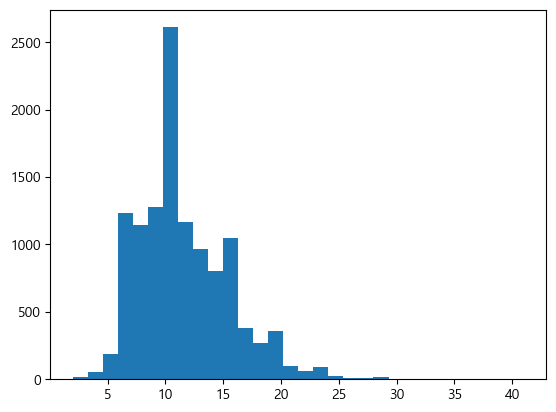

In [26]:
import matplotlib.pyplot as plt
plt.hist(a, 30);

In [27]:
############### Dataset 생성
MAX_LENGTH = 20
dataset = ChatbotDataset(question_texts, answer_texts, MAX_LENGTH, tokenizer)
len(dataset)

11823

In [28]:
dataset[0]

(tensor([  10, 1251, 1449,  368,    3,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 tensor([6120,  378,   47, 2252,    8,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]))

### Trainset / Testset 나누기
train : test = 9 : 1

In [29]:
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
print(train_size, test_size)

10640 1183


In [30]:
# random_split() 이용해서 분리
train_set, test_set = random_split(dataset, [train_size, test_size]) # shuffle 후 개수에 맞게 나눔

### DataLoader 생성

In [31]:
BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [32]:
len(train_loader), len(test_loader) # step 수

(166, 19)

# 모델 정의

## Seq2Seq 모델 정의
- Seq2Seq 모델은 Encoder와 Decoder의 입력 Sequence의 길이와 순서가 자유롭기 때문에 챗봇이나 번역에 이상적인 구조다.
    - 단일 RNN은 각 timestep 마다 입력과 출력이 있기 때문에 입/출력 sequence의 개수가 같아야 한다.
    - 챗봇의 질문/답변이나 번역의 대상/결과 문장의 경우는 사용하는 어절 수가 다른 경우가 많기 때문에 단일 RNN 모델은 좋은 성능을 내기 어렵다.
    - Seq2Seq는 **입력처리(질문,번역대상)처리 RNN과 출력 처리(답변, 번역결과) RNN 이 각각 만들고 그 둘을 연결한 형태로 길이가 다르더라도 상관없다.**

## Encoder
Encoder는 하나의 Vector를 생성하며 그 Vector는 **입력 문장의 의미**를 N 차원 공간 저장하고 있다. 이 Vector를 **Context Vector** 라고 한다.    
![encoder](figures/seq2seq_encoder.png)

In [33]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, bidirectional=True, num_layers=1, dropout_rate=0.0):
        super().__init__()
        # Encoder는 context vector(문장의 feature)를 생성하는 것이 목적(분류기는 생성안함)
        # Embedding Layer, GRU Layer를 생성
        self.vocab_size = vocab_size # 어휘사전의 총 어휘수(토큰 수)
        # 임베딩레이어
        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,  # embedding vector shape : [vocab_size, embedding_dim]
            padding_idx=0
        )
        # GRU
        self.gru = nn.GRU(
            embedding_dim, # 개별 토큰(time step)의 크기
            hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_rate
        )
        
    def forward(self, X):
        X = self.embedding(X) # (batch, seq_len, embedding_dim)
        X = X.transpose(1,0) # (seq_len, batch, embedding_dim)
        out, hidden = self.gru(X)
        return out, hidden

In [34]:
from torchinfo import summary
encoder_model = Encoder(1000, 200, 256)
dummay_data = torch.zeros((64, 20), dtype=torch.int64) # (batch: 64, seq_len:20)
summary(encoder_model, input_data=dummay_data)

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [20, 64, 512]             --
├─Embedding: 1-1                         [64, 20, 200]             200,000
├─GRU: 1-2                               [20, 64, 512]             703,488
Total params: 903,488
Trainable params: 903,488
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 913.26
Input size (MB): 0.01
Forward/backward pass size (MB): 7.29
Params size (MB): 3.61
Estimated Total Size (MB): 10.92

## Decoder
- Encoder의 출력(context vector)를 받아서 번역 결과 sequence를 출력한다.
- Decoder는 매 time step의 입력으로 **이전 time step에서 예상한 단어와 hidden state값이** 입력된다.
- Decoder의 처리결과 hidden state를 Estimator(Linear+Softmax)로 입력하여 **입력 단어에 대한 번역 단어가 출력된다.** (이 출력단어가 다음 step의 입력이 된다.)
    - Decoder의 첫 time step 입력은 문장의 시작을 의미하는 <SOS>(start of string) 토큰이고 hidden state는 context vector(encoder 마지막 hidden state) 이다.

![decoder](figures/seq2seq_decoder.png)

In [35]:
class Decoder(nn.Module):
    def __init__(self,vocab_size, embedding_dim, hidden_size, num_layers=1, bidirectional=False, dropout_rate=0.0):
        super().__init__()
        self.vocab_size= vocab_size # 총 어휘사전 토큰 개수
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # GRU
        ## Auto Regressive RNN은 단반향만 가능 -> bidirectional값은 False로만 준다
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers=num_layers, dropout=dropout_rate)
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        # 분류기 (다음 단어(토큰)를 추론) ->
        #     다중 분류(단어 사전의 단어들의 다음 단어일 확률)
        self.lr = nn.Linear(
            hidden_size, # GRU 출력 값 중 마지막 hidden state값을 입력으로 받음
            vocab_size,  # 출력: 다음 단어일 확률
        )
    
    def forward(self, X, hidden):
        # X: torch.LongTensor: shape - [batch] : 한 단어씩 입력을 받음
        # hidden : torch.FloatTensor: shape - [1, batch, hidden_size] (이전까지의 특성)
        X = X.unsqueeze(1) # seq_len 축을 추가 ,  [batch] -> [batch, 1] (Embedding Layer의 input shape)
        X = self.embedding(X) # [batch, 1, embedding 차원]
        X = X.transpose(1,0) # [1, batch, embedding 차원]
        out, hidden = self.gru(X, hidden)
        last_out = out[-1] # out: 전체 hidden state값  -> out[-1]은 마지막 hidden state을 추출
        last_out = self.lr(last_out)
        return last_out, hidden  # hidden: 다음 timestep에 전달

In [36]:
#### summary
decoder_model = Decoder(1000, 200, 256)
dummay_input = torch.ones((64, ), dtype=torch.int64)
dummay_hidden = torch.ones((1, 64, 256), dtype=torch.float32)
summary(decoder_model, input_data=(dummay_input, dummay_hidden))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [64, 1000]                --
├─Embedding: 1-1                         [64, 1, 200]              200,000
├─GRU: 1-2                               [1, 64, 256]              351,744
├─Linear: 1-3                            [64, 1000]                257,000
Total params: 808,744
Trainable params: 808,744
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.76
Input size (MB): 0.07
Forward/backward pass size (MB): 0.75
Params size (MB): 3.23
Estimated Total Size (MB): 4.05

## Seq2Seq 모델

- Encoder - Decoder 를 Layer로 가지며 Encoder로 질문의 feature를 추출하고 Decoder로 답변을 생성한다.

### Teacher Forcing
- **Teacher forcing** 기법은, RNN계열 모델이 다음 단어를 예측할 때, 이전 timestep에서 예측된 단어를 입력으로 사용하는 대신 **실제 정답 단어(ground truth) 단어를** 입력으로 사용하는 방법이다.
    - 모델은 이전 시점의 출력 단어를 다음 시점의 입력으로 사용한다. 그러나 모델이 학습할 때 초반에는 정답과 많이 다른 단어가 생성되어 엉뚱한 입력이 들어가 학습이 빠르게 되지 않는 문제가 있다.
- **장점**
    - **수렴 속도 증가**: 정답 단어를 사용하기 때문에 모델이 더 빨리 학습할 수있다.
    - **안정적인 학습**: 초기 학습 단계에서 모델의 예측이 불안정할 때, 잘못된 예측으로 인한 오류가 다음 단계로 전파되는 것을 막아줍니다.
- **단점**
    - **노출 편향(Exposure Bias) 문제:** 실제 예측 시에는 정답을 제공할 수 없으므로 모델은 전단계의 출력값을 기반으로 예측해 나가야 한다. 학습 과정과 추론과정의 이러한 차이 때문에 모델의 성능이 떨어질 수있다.
        - 이런 문제를 해결하기 학습 할 때 **Teacher forcing을 random하게 적용하여 학습시킨다.**
![seq2seq](figures/seq2seq.png)

In [76]:
SOS_TOKEN = tokenizer.token_to_id("[SOS]")
SOS_TOKEN

class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device
        
    def forward(self, inputs, outputs, teacher_forcing_rate=0.99):
        """
        parameter
            inputs: 질문 - (batch, seq_length)
            outputs: 답변(정답) - (batch, seq_length)
            teacher_forcing_rate: teacher_forcing 적용 확률.
        """
        if inputs.dim() == 1: # (seq_length) # 질문이 한개일 경우 질문 문장 토큰만 입력될 수있다.
            inputs = inputs.unsqueeze(0) # (1, seq_length)

        if outputs.dim() == 1:
            outputs = inputs.unsqueeze(0)

        batch_size, output_length = outputs.shape
        output_vocab_size = self.decoder.vocab_size  # 어휘사전 토큰 총 개수.

        # 생성된 문장을 저장할 변수
        ## (seq length, batch size, vocab_size(단어별 확률))
        predicted_outputs = torch.zeros(output_length, batch_size, output_vocab_size).to(self.device)

        ###### encoder를 이용해서 질문 문장의 context vector 추출.
        encoder_out, encoder_hidden = self.encoder(inputs)
        # encoder_out: [seq_len, batch, hidden_size * 2(양방향-단방향:1)]
        # encoder_hidden: [2(양방향-단방향:1), batch, hidden_size]

        decoder_hidden = encoder_out[-1].unsqueeze(0) # [1, batch, hidden] #마지막 hidden state
        # Decoder에 넣을 첫번째 time step의 값: [SOS]
        decoder_input = torch.full((batch_size, ), fill_value=SOS_TOKEN, device=self.device)

        # 순회(반복) 하면서 단어들을 하나씩 생성. 
        for t in range(output_length): # max_length 만큼 생성.
            # decoder_input(개별토큰id): [batch_size] - 첫 timestep: [SOS], 두번째: 생성된 토큰
            # decoder_out(batch_size, vocab_size): 다음 단어일 확률
            # decoder_hidden(1, batch, hidden * 2(양방향, 단: 1)) - 현재 입력의 feature(다음 timestep의 hidden으로 사용)
            decoder_out, decoder_hidden = self.decoder(decoder_input, decoder_hidden) 

            predicted_outputs[t] = decoder_out # t 번째 예측 단어를 저장.

            #### 다음 timestep에 넣어줄 값을 생성. 
            ##### teacher_forcing 적용: 정답, 비적용: 모델이 추론한 결과
            teacher_forcing = teacher_forcing_rate > random.random()
            # teacher_forcing_rate의 확률만큼 True. 
            teacher_forcing_rate = teacher_forcing_rate * 0.99 
            # 점점 t_f이 적용될 가능성을 줄인다.
                          #    (모델이 추론한 값이 다음 입력으로 사용할 확률을 높여준다.)

            # 모델이 추론한 단어중 가장 확률이 높은(TOP-1) 단어를 추출 
            top1 = decoder_out.argmax(-1)
            # teacher_foring이 True: 정답, False: 예측(top1)
            decoder_input = outputs[:, t] if teacher_forcing else top1

        return predicted_outputs.transpose(1, 0) # (batch, seq_length, vocab_size) 변환.

In [66]:
# random.random() # 랜덤값 생성 - 0 ~ 1 실수를 반환,  모든 값들이 나올 확률은 동일

# 학습

## 모델생성

In [77]:
#  하이퍼파라미터들 정의
VOCAB_SIZE = tokenizer.get_vocab_size()

ENCODER_BIDIRECTIONAL = True # 인코더 양방향 여부
ENCODER_HIDDEN_SIZE = 200    # 인코더 hidden_size
DECODER_HIDDEN_SIZE = ENCODER_HIDDEN_SIZE * 2 if ENCODER_BIDIRECTIONAL else ENCODER_HIDDEN_SIZE
EMBEDDING_DIM = 256  # 임베딩 차원수
TEACHER_FORCING_RATE = 0.9

In [78]:
VOCAB_SIZE

7041

In [79]:
### 모델 생성
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=ENCODER_HIDDEN_SIZE,
    num_layers=1,
    bidirectional=ENCODER_BIDIRECTIONAL
)
decoder = Decoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_size=DECODER_HIDDEN_SIZE,
    num_layers=1  # auto regressive 모델이므로 단방향 GRU생성.
)
model = Seq2Seq(encoder, decoder, device)

In [70]:
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7041, 256, padding_idx=0)
    (gru): GRU(256, 200, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(7041, 256, padding_idx=0)
    (gru): GRU(256, 400)
    (dropout): Dropout(p=0.0, inplace=False)
    (lr): Linear(in_features=400, out_features=7041, bias=True)
  )
)


## loss함수, optimizer

In [80]:
LR = 0.001
model = model.to(device)
# 다음 단어를 추론하는 다중분류
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

## train/evaluation 함수 정의

### train 함수정의

In [81]:
# 1 epoch 학습 함수.
def train_fn(model, data_loader, optimizer, loss_fn, device, 
             teacher_forcing_rate=0.99):

    model.train()  # Seq2Seq모델.
    loss_list = [] # step별 loss를 저장.

    for X, y in data_loader:
        # device 로 이동
        X, y = X.to(device), y.to(device)
        # 추론
        pred = model(X, y, teacher_forcing_rate)
        # pred: 추론한 답변 문장: (batch, seq_length, vocab_size:토큰일 확률)
        
        # pred와 정답의 shape을 변경 (loss 함수에 넣을 수 있는 shape으로 변환.)
        # pred를 reshape (batch, seq_len, vocab_size) -> (batch*seq_len, vocab_size)
        y_hat = pred.reshape(-1, pred.shape[2]) 
        # 정답(y)을 reshape (batch, seq_len:토큰수) -> (batch * seq_len)
        y = y.reshape(-1)
        # CrossEntropyLoss(): 정답 - 원핫인코딩 안된 형태, 추론값: softmax 처리 안된 상태
        #       - 정답  shape: (batch, )
        #       - 추론값shape: (batch, class개수)

        # Loss 계산
        loss = loss_fn(y_hat, y)
        # gradient 계산
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 파라미터 초기화
        optimizer.zero_grad()
        loss_list.append(loss.item())
    return np.mean(loss_list)

### Test 함수

In [82]:
def test_fn(model, data_loader, loss_fn, device):
    
    # 1 에폭 테스트
    model.eval()
    loss_list = []

    with torch.no_grad():
        for X, y in data_loader:
            # 이동
            X, y = X.to(device), y.to(device)
            pred = model(X, y, teacher_forcing_rate=0.0)
            y_hat = pred.reshape(-1, pred.shape[2])
            y = y.reshape(-1)
            loss_list.append(loss_fn(y_hat, y).item())
    
    return np.mean(loss_list)

### Training

In [84]:
EPOCHS = 1

best_loss = np.inf
s = time.time()

for epoch in range(EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, loss_fn, 
                          device, TEACHER_FORCING_RATE)
    val_loss = test_fn(model, test_loader, loss_fn, device)

    # 저장
    if val_loss < best_loss:
        print(f"{epoch}에서 저장. {best_loss:.5f}에서 {val_loss:.5f}로 개선됨.")
        best_loss = val_loss

    print(f"[{epoch}/{EPOCHS}] train loss: {train_loss}, val loss: {val_loss}")

e = time.time()
print("걸린시간:", (e-s))

0에서 저장. inf에서 2.35519로 개선됨.
[0/1] train loss: 1.9552086290106716, val loss: 2.3551917201594303
걸린시간: 273.2237389087677


In [85]:
MODEL_SAVE_PATH = 'saved_model/seq2seq-chatbot-model.pt'
torch.save(model, MODEL_SAVE_PATH)

In [87]:
# 저장 모델 Load
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model = torch.load(MODEL_SAVE_PATH, weights_only=False, map_location=device)
best_model.device # Attribute device를 현재 device로 지정

# last_model = torch.load(MODEL_SAVE_LAST, weights_only=False, map_location=device)
# last_model.device # Attribute device를 현재 device로 지정

'cpu'

# 결과확인

In [111]:
from torch.utils.data import SubsetRandomSampler


def handle_special_tokens(decoded_string):
    """
    Subword 처리
    subword는 단어의 시작으로 쓰인 것과 중간 부분(연결)에 사용된 두가지 subword가 있다.  연결 subword는 `#`과 같은 특수문자로 시작 한다.
    tokenizer.decode() 결과 문자열은 subword의 특수문자('#')을 처리하지 않는다. 이것을 처리하는 함수
    ex) "이 기회 ##는 내 ##꺼 #야" ==> "이 기회는 내꺼야"
    
    Parameter
        decoded_string: str - Tokenizer가 decode한 중간 subword의 특수문자 처리가 안된 문자열. 
    Return
        str: subword 특수문자 처리한 문자열
    """
    tokens = decoded_string.split() # 공백 기준으로 토큰화
    new_tokens = []
    for token in tokens:
        if token.startswith("##"): # 연결 토큰
            if new_tokens: # len(new_token) != 0 원소가 하나라도 있으면
                # 토큰에서 ##을 제거하고 리스트의 마지막 원소(문자열) 뒤에 붙인다ㄷ
                new_tokens[-1] += token[2:]
            else: # new_tokens가 빈 리스트, 현재 token이 첫번째 단어 ##을 지우고 append
                new_tokens.append(token[2:])
        else: # 단어의 시작인 토큰  (##이 없는 토큰) -> list에 가
            new_tokens.append(token)
            
    return " ".join(new_tokens)
# dataset에서 일부 데이터들을 가지고 확인
def random_evaluation(model, dataset, device, n=10):
    """
    Dataset에서 일부 질문-답변 쌍들을 가져다 모델에 질문을 넣어 추론한 결과와 함께 확인.
    Parameter
        model: 학습된 seq2seq 모델
        dataset: 질문-답변 쌍울 추출할 dataset
        device
        n: int - 추출할 질문-답변 쌍 개수 default: 10
    """
    ## 평가할 데이터셋을 만들기
    n_samples = len(dataset) # Dataset의 총 데이터 개수
    index = list(range(n_samples)) # Dataset의 index만들기
    np.random.shuffle(index) # 값들을 랜덤하게 섞어준다.
    sample_index = index[ : n] # 평가할 데이터 개수만큼 index 생성
    
    # Dataloader 생성
    # SubsetRandomSampler: 지정한 index들 안에서 random한 순서로 제공
    sample = SubsetRandomSampler(sample_index)
    sample_loader = DataLoader(dataset, batch_size=n, sampler=sample)
    # 추론 후 확인
    model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in sample_loader:
            X, y = X.to(device), y.to(device)
            output = model(X, y, 0.0)

            # torch.Tensor -> ndarray(tokenizer decode에 넣기 위해)
            ## tensor를 cpu로 이동후 변환 가능
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            y = y.cpu().numpy()

            for i in range(n):
                q = handle_special_tokens(tokenizer.decode(X[i]))
                a = handle_special_tokens(tokenizer.decode(y[i]))
                p = handle_special_tokens(tokenizer.decode(pred[i].argmax(-1)))
                print(f"질문: {q}")
                print(f"정답: {a}")
                print(f"예측: {p}")
                print('============================================================')

- Sampler:
    - DataLoader가 Dataset의 값들을 읽어서 batch를 만들때 index 순서를 정해주는 객체
    - DataLoader의 기본 sampler는 SequentialSampler 이다. shuffle=True 일 경우 RandomSampler: 랜덤한 순서로 제공

In [112]:
# e = tokenizer.encode('일부 질문-답변 쌍들을 가져다 모델에 질문')
# txt = tokenizer.decode(e.ids)
# txt, handle_special_tokens(txt)
print("============== Best Model ===============")
random_evaluation(best_model,test_set, device)

============== Best Model ===============
질문: 집안일이 너무 많아
정답: 하나씩 하세요 .
예측: 좋은 만남이었길 .
질문: 나랑 썸 타는 줄 알았는데 내 동기랑 사귐 .
정답: 찔러본 건가봐요 .
예측: 마음이 많이 . .
질문: 나를 떠보는 것 같은 짝남 .
정답: 떠보는 것보다 직구 날려보세요 .
예측: 마음이 많이 . .
질문: 미치겠습니다
정답: 무슨 일 있었나봐요 .
예측: 좋은 만남이었길 .
질문: 이별을 해야하나봐
정답: 마음이 문제네요 .
예측: 그 사람 . .
질문: 남사친이 좋아졌으면 어떡해 ?
정답: 좋아진 이상 이성으로 다가가야죠 .
예측: 그 사람 . .
질문: 이젠 나의 스케줄로 돌아가야할때 !!
정답: 좋은 생각이에요 !
예측: 좋은 만남이었길 .
질문: 잠겨 죽어도 좋으니 너는 물처럼 내게 밀려오라 .
정답: 나도 모르게 내 맘 속 심어진 감정의 씨앗 .
예측: 그 사람 . .
질문: 티 안 나게 나 싫어해
정답: 여우인가봐요 .
예측: 좋은 만남이었길 .
질문: 내가 좋아하는 사람이 누군지 점점 헷갈려 .
정답: 결정적인 감정의 변화가 없었나봐요 .
예측: 그 사람 . .


# 새로운 데이터 추론

In [113]:
class ChatbotInputDataset(Dataset):
    """
    질문만 받아서 생성하는 Dataset
    - 새로운 데이터 추론용. (서비스)
    """

    def __init__(self, question_texts, max_length, tokenizer):
        """
        parameter
            question_texts: list[str] - 질문 texts 목록. 리스트에 질문들을 담아서 받는다. ["질문1", "질문2", ...]
            max_length: 개별 문장의 token 개수. 모든 문장의 토큰수를 max_length에 맞춘다.
            tokenizer: Tokenizer
        """
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.question_texts = [self.__process_sequence(a) for a in question_texts]
    
    def __pad_token_sequence(self, token_sequence):
        """
        max_length 길이에 맞춰 token_id 리스트를 구성한다.
        max_length 보다 길면 뒤에를 자르고 max_length 보다 짧으면 [PAD] 토큰을 추가한다.
        
        Parameter
            token_sentence: list[int] - 길이를 맞출 한 문장 token_id 목록
        Return
            list[int] - length가 max_length인 token_id 목록
        """
        pad_token = self.tokenizer.token_to_id('[PAD]')
        seq_len = len(token_sequence) # 입력 문장의 토큰수
        if seq_len > self.max_length: # 문장 최대 토큰수 보다 길다면.
            return token_sequence[:self.max_length]
        else:
            return token_sequence + ([pad_token] * (self.max_length - seq_len))
    
    def __process_sequence(self, text):
        """
        한문장을 받아서 padding이 추가된 token_id 리스트로 변환 후 반환
        Parameter
            text: str - token_id 리스트로 변환할 한 문장
        Return
            list[int] - 입력받은 문장에 대한 token_id 리스트
        """
        # encoding
        encode = self.tokenizer.encode(text) # "......" => [. , . , .]
        # max_length 크기에 맞춘다.
        token_ids = self.__pad_token_sequence(encode.ids)
        return token_ids
    
    def __len__(self):
        return len(self.question_texts)

    
    def __getitem__(self, index):
        # return  index의 (질문토큰들,  답변토큰들)
        q = self.question_texts[index]  # List
        # List->LongTensor. nn.Embedding()의 입력(정수타입)으로 들어간다. 
        return torch.tensor(q, dtype=torch.int64)#, torch.tensor(a, dtype=torch.int64)
        

In [137]:
input_data = [
    "난 가족들과 주말에 여행갈 거야.",
    "와! 내일 주말이다.",
    "난 햄버거를 먹을 거야.",
    "너무 피곤하네요, 좀 쉬었으면 좋겠어요.",
    "지금 몇시에요.",
    "여자 친구와 내일 저녁에 만나기로 했어",
    "책 이름이 뭐야?"
]
input_dataset = ChatbotInputDataset(input_data, MAX_LENGTH, tokenizer)

In [146]:
def predict(dataset, model, device):
    model.eval()
    model.to(device)

    with torch.no_grad():
        for X in dataset: # Dataset에서 한 질문씩을 조회
            X = X.to(device)
            output = model(X.unsqueeze(0), X.unsqueeze(0), 0.0)
            pred = output.cpu().numpy()
            X = X.cpu().numpy()
            q = handle_special_tokens(tokenizer.decode(X))
            a = handle_special_tokens(tokenizer.decode(pred[0].argmax(-1)))
            print(f'질문 : {q}')
            print(f'예상 답: {a}')
            print("==========================================")

In [147]:
predict(input_dataset, best_model, device)

질문 : 난 가족들과 주말에 여행갈 거야 .
예상 답: 좋은 생각이에요 .
질문 : 와 ! 내일 주말이다 .
예상 답: 좋은 만남이었길 .
질문 : 난버거를 먹을 거야 .
예상 답: 좋은 만남이었길 .
질문 : 너무 피곤하네요 , 좀 쉬었으면 좋겠어요 .
예상 답: 좋은 소식이네요 .
질문 : 지금 몇시에요 .
예상 답: 좋은 소식이네요 .
질문 : 여자 친구와 내일 저녁에 만나기로 했어
예상 답: 좋은 만남이었길 .
질문 : 책 이름이 뭐야 ?
예상 답: 그 사람 . .
